In [93]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxa
import geopandas as gpd
from scipy.optimize import curve_fit

In [ ]:
import pickle
# import os
# with open(os.path.expanduser('~/Documents/taus.pkl'), 'wb') as f:
#     pickle.dump(taus, f)

In [3]:
ds = xr.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/cor_vv.nc')

In [4]:
def temp_model(T, tau):
    return np.exp(-T/tau)

In [139]:
def tau(cors, days):
    if np.sum(np.isnan(cors)) == 0:
        s = curve_fit(temp_model, days, cors, 5)[0][0]
        return s
    else:
        return np.nan

In [133]:
cors = ds['cor_vv'].values[:, 2001, 3000]

In [51]:
days = np.array([int(d.split('_')[-1].replace('d','')) for d in ds['band'].values])

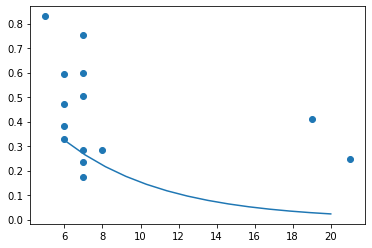

In [110]:
cors = ds['cor_vv'].values[:, 2006, 3006]
plt.scatter(days, cors)
xs = np.linspace(6, 20, 14)
s = curve_fit(temp_model, days, cors, 5)[0][0]
pred = temp_model(xs, 5.32231228)
plt.plot(xs, pred)

In [140]:
taus = np.apply_along_axis(arr = ds['cor_vv'].values, func1d = tau, axis = 0, days = days)

In [151]:
with open('/Users/zachkeskinen/Documents/uavsar/data/cor_coarse.pkl' , 'rb') as f:
    cor_coarse = pickle.load(f)

In [156]:
dem = rxa.open_rasterio('../../../data/dem.tiff')

roads = '/bsuhome/zacharykeskinen/scratch/data/uavsar/roads/Shape/Trans_RoadSegment.shp'
roads = '../../../data/aucillary/roads/Shape/Trans_RoadSegment.shp'
roads = gpd.read_file(roads)
hwy21 = roads[roads.state_ro_1 == '21']
trees = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/tree_less.shp')
fires = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/mtbs_perimeter_data/mtbs_perims_DD.shp')

In [325]:
trees = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/tree_less.shp')

In [249]:
lc = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/id_16/nlcd_id_utm11.tif')

In [264]:
lc = lc.rio.reproject_match(dem)

In [308]:
water = lc.copy()
water = water.where(water == 11)
barren = lc.copy()
barren = barren.where(barren == 31)

In [327]:
deep_snow = gpd.read_file('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/deep_snow.shp')

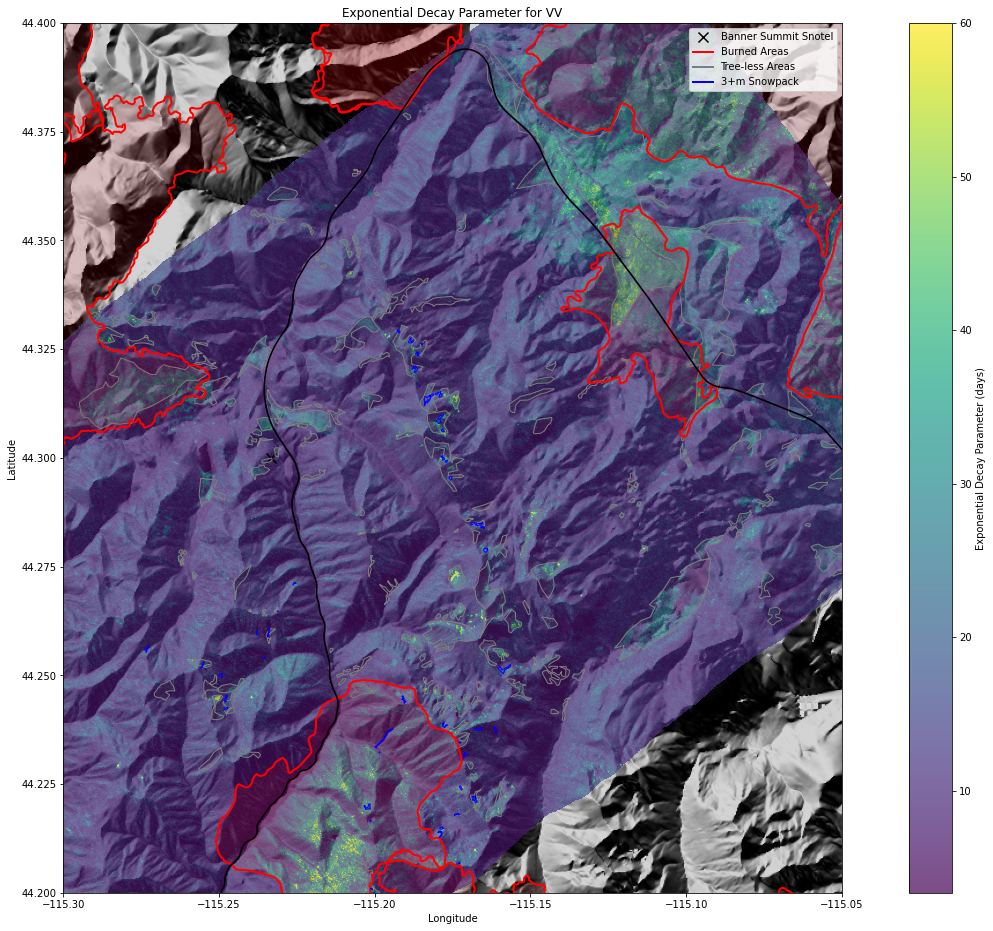

In [331]:
from matplotlib.colors import LightSource
figdir = '/Users/zachkeskinen/Documents/uavsar/figures/coherence_spatial'
fig, ax = plt.subplots(figsize = (24,16))

dx = 0.0005
dy = 0.0005
conversion = 6

ls = LightSource(azdeg = 315, altdeg = 45)
cmap = plt.cm.gist_earth
rgb = ls.hillshade(dem.values[0], vert_exag=10, dx = dx*conversion, dy = dy*conversion)
plt.imshow(rgb, extent = (dem.x.min().data,dem.x.max().data, dem.y.min().data, dem.y.max().data), cmap = 'gray')
plt.imshow(taus, vmax = 60, alpha = 0.7, extent = (dem.x.min().data,dem.x.max().data, dem.y.min().data, dem.y.max().data))
plt.colorbar(fraction = 0.1, label = 'Exponential Decay Parameter (days)')
# add some other pieces
snotel_coords = (-115.2333, 44.3)
plt.scatter(*snotel_coords, s = 100, marker = 'x', color = 'black', label = 'Banner Summit Snotel')
hwy21.plot(ax = ax, label = '_HWY 21', color = 'black')
trees.plot(fc = 'none', ec = 'grey', linewidth = 1, ax= ax)
trees.plot(fc = 'grey', ec = 'none', linewidth = 1, ax= ax, alpha = 0.1)
# water.plot(ax = ax, alpha = 0.4)
# barren.plot(ax = ax, alpha = 0.4)

fires.plot(ax = ax, fc = 'red', ec ='none', linewidth = 2, alpha = 0.1)
fires.plot(ax = ax, fc = 'none', ec ='red', linewidth = 2, alpha = 1)
plt.plot([1,1],[1,1], linewidth = 2, color = 'red', label = 'Burned Areas')
plt.plot([1,1],[1,1], linewidth = 2, color = 'slategrey', label = 'Tree-less Areas')
# plt.plot([1,1],[1,1], linewidth = 2, color = 'blue', label = 'Open Water')
deep_snow.plot(ax =ax , fc = 'blue', alpha = 0.1)
deep_snow.plot(ax =ax , fc = 'none',ec = 'blue', linewidth = 1)
plt.plot([1,1],[1,1], linewidth = 2, color = 'blue', label = '3+m Snowpack')

plt.xlim(-115.3, -115.05)
plt.ylim(44.2, 44.4)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend()
plt.title('Exponential Decay Parameter for VV')
plt.savefig(join(figdir, 'tau_VV_lowman.png'))